# Euro 2024 - Web Scrapping Pipeline

## Web Scrapping Pipeline

In [670]:
# Hungarian flag codes: https://www.flagcolorcodes.com/hungary

# Importing needed libraries
import json
import time
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
from typing import List, Optional
from selenium import webdriver
from supabase import create_client, Client
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import to_rgba
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.image as mpimg
from mplsoccer import Pitch, FontManager, Sbopen
import urllib
from PIL import Image
from mplsoccer import Pitch, VerticalPitch, FontManager, Sbopen

pd.options.mode.chained_assignment = None  # default='warn'

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [642]:
# Setting up web driver
driver = webdriver.Chrome()

In [643]:
# Using Input for inputting the url of the game
whoscored_url = input('Enter the URL of the game: ')

Enter the URL of the game:  https://www.whoscored.com/Matches/1787328/Live/International-European-Championship-2024-Hungary-Switzerland


In [644]:
# set the driver for the url
driver.get(whoscored_url)

In [645]:
# Previous line of code will take a while
# Creating the soup element. We will get the HTML code of the page
soup = BeautifulSoup(driver.page_source, 'html.parser')

# Selecting the block of code we are interested in
# Right click -> View Source Code -> Look for the MatchCentreData
element = soup.select_one('script:-soup-contains("matchCentreData")')

# Extracting the dictionary of events data.
# There is a primary key 'id' and an eventId associated with each record
# Coming in JSON format, preferred by web/app developers
matchdict = json.loads(element.text.split("matchCentreData: ")[1].split(',\n')[0])

## Data Cleaning

In [646]:
# Example of the output (one event in particular)
# The event below refers to a Pass -> type:Pass
matchdict['events'][50]

{'id': 2696174043.0,
 'eventId': 26,
 'minute': 2,
 'second': 23,
 'teamId': 423,
 'playerId': 381550,
 'x': 77.9,
 'y': 96.6,
 'expandedMinute': 2,
 'period': {'value': 1, 'displayName': 'FirstHalf'},
 'type': {'value': 74, 'displayName': 'BlockedPass'},
 'outcomeType': {'value': 1, 'displayName': 'Successful'},
 'qualifiers': [{'type': {'value': 285, 'displayName': 'Defensive'}},
  {'type': {'value': 233, 'displayName': 'OppositeRelatedEvent'},
   'value': '26'},
  {'type': {'value': 56, 'displayName': 'Zone'}, 'value': 'Left'}],
 'satisfiedEventsTypes': [91, 60],
 'isTouch': True}

In [647]:
# Filtering using variable definition for only storing events dictionary data
match_events = matchdict['events']

# Converting JSON data into a pandas dataframe
df = pd.DataFrame(match_events)

# Dropping all rows that do not include a player ID
df.dropna(subset='playerId', inplace=True)

# Replacing all NaN values to None
df = df.where(pd.notnull(df), None)

# Renaming columns to ensure consistency and data integrity
df = df.rename(
    {
        'eventId': 'event_id',
        'expandedMinute': 'expanded_minute',
        'outcomeType': 'outcome_type',
        'isTouch': 'is_touch',
        'playerId': 'player_id',
        'teamId': 'team_id',
        'endX': 'end_x',
        'endY': 'end_y',
        'blockedX': 'blocked_x',
        'blockedY': 'blocked_y',
        'goalMouthZ': 'goal_mouth_z',
        'goalMouthY': 'goal_mouth_y',
        'isShot': 'is_shot',
        'cardType': 'card_type',
        'isGoal': 'is_goal'
    },
    axis=1
)
              
df.head(2)              

,id,event_id,minute,second,team_id,x,y,expanded_minute,period,type,outcome_type,qualifiers,satisfiedEventsTypes,is_touch,player_id,end_x,end_y,relatedEventId,relatedPlayerId,blocked_x,blocked_y,goal_mouth_z,goal_mouth_y,is_shot,card_type,is_goal
2,2.696173e+09,3,0,0.0,327,50.0,50.0,0,"{'value': 1, 'displayName': 'FirstHalf'}","{'value': 1, 'displayName': 'Pass'}","{'value': 1, 'displayName': 'Successful'}","[{'type': {'value': 140, 'displayName': 'PassE...","[91, 117, 30, 35, 37, 216, 218]",True,295362.0,34.2,69.3,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None
3,2.696173e+09,4,0,3.0,327,34.2,69.3,0,"{'value': 1, 'displayName': 'FirstHalf'}","{'value': 1, 'displayName': 'Pass'}","{'value': 1, 'displayName': 'Successful'}","[{'type': {'value': 213, 'displayName': 'Angle...","[91, 117, 30, 36, 37, 216, 218]",True,369875.0,40.1,85.1,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None


In [648]:
# Creating new columns from the dictionaries within the dataset variables (df['period', 'type'], etc)
df['period_display_name'] = df['period'].apply(lambda x: x['displayName'])  # The displayname variable is a key within the dictionary within the dataset (json)
df['type_display_name'] = df['type'].apply(lambda x: x['displayName'])
df['outcome_type_display_name'] = df['outcome_type'].apply(lambda x: x['displayName'])

# Creating a column of 'is_goal' for games without goals. 
# Otherwise it will create errors
if 'is_goal' not in df.columns:
    print('missing goals')
    df['is_goal'] = False
    
# Fixing for offside given
# Dropping rows that have the offisde given
df = df[~(df['type_display_name'] == "OffsideGiven")]

# Dropping the initial dictionary columns since we don't need them anymore
df.drop(columns = ['period', 'type', 'outcome_type'], inplace=True)

df.head(2)

,id,event_id,minute,second,team_id,x,y,expanded_minute,qualifiers,satisfiedEventsTypes,is_touch,player_id,end_x,end_y,relatedEventId,relatedPlayerId,blocked_x,blocked_y,goal_mouth_z,goal_mouth_y,is_shot,card_type,is_goal,period_display_name,type_display_name,outcome_type_display_name
2,2.696173e+09,3,0,0.0,327,50.0,50.0,0,"[{'type': {'value': 140, 'displayName': 'PassE...","[91, 117, 30, 35, 37, 216, 218]",True,295362.0,34.2,69.3,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,FirstHalf,Pass,Successful
3,2.696173e+09,4,0,3.0,327,34.2,69.3,0,"[{'type': {'value': 213, 'displayName': 'Angle...","[91, 117, 30, 36, 37, 216, 218]",True,369875.0,40.1,85.1,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,FirstHalf,Pass,Successful


In [649]:
df.columns

Index(['id', 'event_id', 'minute', 'second', 'team_id', 'x', 'y',
       'expanded_minute', 'qualifiers', 'satisfiedEventsTypes', 'is_touch',
       'player_id', 'end_x', 'end_y', 'relatedEventId', 'relatedPlayerId',
       'blocked_x', 'blocked_y', 'goal_mouth_z', 'goal_mouth_y', 'is_shot',
       'card_type', 'is_goal', 'period_display_name', 'type_display_name',
       'outcome_type_display_name'],
      dtype='object')

In [650]:
'''
Before moving forward, make sure you verify the columns of the dataset.
Depending on the league, some variables will differ. 
For example, the Spanish league has a 'card_type' variable, while the Eredivisie does not.
'''
# Defining and keeping only desired columns
df = df[[ 
    'id', 'event_id', 'minute', 'second', 'team_id', 'player_id', 'x','y', 'end_x', 'end_y', 
    'qualifiers', 'is_touch', 'blocked_x', 'blocked_y', 'goal_mouth_z', 'goal_mouth_y', 'is_shot', 'is_goal', 'type_display_name', 'outcome_type_display_name',
    'period_display_name'
]]

# -- Variables not used: , 'card_type'

# Defining the types of each variable
df[['id', 'event_id', 'minute', 'team_id', 'player_id']] = df[['id', 'event_id', 'minute', 'team_id', 'player_id']].astype(int) 
df[['second', 'x', 'y', 'end_x', 'end_y']] = df[['second', 'x', 'y', 'end_x', 'end_y']].astype(float)
df[['is_shot', 'is_goal']] =df[['is_shot', 'is_goal']].astype(bool)

df['is_goal'] = df['is_goal'].fillna(False)
df['is_shot'] = df['is_shot'].fillna(False)

# -- Variables not used: , 'card_type'

# Loop for ensuring accuracy of the columns
# Pandas & Numpy treat the NaN differently, this will help to assign as None all of those values that previously didn't change from NaN to None
for column in df.columns:
    if df[column].dtype == np.float64 or df[column].dtype == np.float32:
        df[column] = np.where(
            np.isnan(df[column]),
            None,
            df[column]
        )
        
df.head(2)

,id,event_id,minute,second,team_id,player_id,x,y,end_x,end_y,qualifiers,is_touch,blocked_x,blocked_y,goal_mouth_z,goal_mouth_y,is_shot,is_goal,type_display_name,outcome_type_display_name,period_display_name
2,2696173437,3,0,0.0,327,295362,50.0,50.0,34.2,69.3,"[{'type': {'value': 140, 'displayName': 'PassE...",True,None,None,None,None,False,False,Pass,Successful,FirstHalf
3,2696173441,4,0,3.0,327,369875,34.2,69.3,40.1,85.1,"[{'type': {'value': 213, 'displayName': 'Angle...",True,None,None,None,None,False,False,Pass,Successful,FirstHalf


## Appending Player Data

In [651]:
# Create a new variable to store the new coming information
# We then later will merge it with initial database
team_info = []

# Appending player information of Home team
team_info.append({
    'team_id': matchdict['home']['teamId'],
    'name': matchdict['home']['name'],
    'country_name': matchdict['home']['countryName'],
    'manager_name': matchdict['home']['managerName'],
    'players': matchdict['home']['players'],
})

# Appending player information of Away team
team_info.append({
    'team_id': matchdict['away']['teamId'],
    'name': matchdict['away']['name'],
    'country_name': matchdict['away']['countryName'],
    'manager_name': matchdict['away']['managerName'],
    'players': matchdict['away']['players'],
})


# Creating function for storing player information into new list
def insert_players(team_info):
    players = []
    
    for team in team_info:
        for player in team['players']:
            players.append({
                'player_id': player['playerId'],
                'team_id': team['team_id'],
                'shirt_no': player['shirtNo'],
                'name': player['name'],
                'position': player['position'],
                'age': player['age'],
                'MOTM': player['isManOfTheMatch'] # Might not have in Euro (Doble check later)
            })
    return players

# Creating function for storing team information and name
def insert_team(team_info):
    teams = []
    for team in team_info:
        teams.append({
          'team_id': team['team_id'],
          'team': team['name']
        })
    return teams

# Applying functions
players = insert_players(team_info)
teams = insert_team(team_info)

# Converting JSON data into a pandas dataframe
players_df = pd.DataFrame(players)
teams_df = pd.DataFrame(teams)

In [652]:
players_df.head(3)

,player_id,team_id,shirt_no,name,position,age,MOTM
0,67369,327,1,Péter Gulácsi,GK,34,False
1,104917,327,6,Willi Orbán,DC,31,False
2,117962,327,2,Ádám Lang,DC,31,False


In [653]:
teams_df

,team_id,team
0,327,Hungary
1,423,Switzerland


## Merging Events data with Player Data

In [654]:
# We are going to do the merge on player_id.
# SQL Schema -> primary key in Players table and foreign key in events
players_df = pd.merge(players_df, teams_df, on='team_id')
final_df = pd.merge(df, players_df, on='player_id')

# Sorting the df in ascending for minute and second
final_df = final_df.sort_values(by=['minute', 'second'], ascending=True)

# Resetting the index if needed
final_df = final_df.reset_index(drop=True)

# Setting up the name for the file
# Finding all positions of '-'
positions = [pos for pos, char in enumerate(whoscored_url) if char == '-']

# Getting the position of the second to last '-'
second_to_last_dash_position = positions[-2]

# Slicing the string from the second to last '-' to the end
new_variable = whoscored_url[second_to_last_dash_position + 1:]

# Saving the file for later in CSV
final_df.to_csv(f'/Users/enzovillafuerte/Desktop/Python_Projects/Hungary_Euro_Report/Datasets/{new_variable}.csv', index=False)

final_df.head()

,id,event_id,minute,second,team_id_x,player_id,x,y,end_x,end_y,qualifiers,is_touch,blocked_x,blocked_y,goal_mouth_z,goal_mouth_y,is_shot,is_goal,type_display_name,outcome_type_display_name,period_display_name,team_id_y,shirt_no,name,position,age,MOTM,team
0,2696173437,3,0,0.0,327,295362,50.0,50.0,34.2,69.3,"[{'type': {'value': 140, 'displayName': 'PassE...",True,None,None,None,None,False,False,Pass,Successful,FirstHalf,327,8,Ádám Nagy,MC,28,False,Hungary
1,2696173441,4,0,3.0,327,369875,34.2,69.3,40.1,85.1,"[{'type': {'value': 213, 'displayName': 'Angle...",True,None,None,None,None,False,False,Pass,Successful,FirstHalf,327,10,Dominik Szoboszlai,AMC,23,False,Hungary
2,2696173461,5,0,6.0,327,317508,42.2,84.5,66.5,27.4,"[{'type': {'value': 141, 'displayName': 'PassE...",True,None,None,None,None,False,False,Pass,Successful,FirstHalf,327,4,Attila Szalai,DC,26,False,Hungary
3,2696173465,6,0,8.0,327,243889,64.5,27.6,71.8,0.0,"[{'type': {'value': 141, 'displayName': 'PassE...",True,None,None,None,None,False,False,Pass,Unsuccessful,FirstHalf,327,20,Roland Sallai,AMC,27,False,Hungary
4,2696173493,4,0,16.0,423,327702,22.7,100.0,23.8,86.0,"[{'type': {'value': 212, 'displayName': 'Lengt...",True,None,None,None,None,False,False,Pass,Successful,FirstHalf,423,20,Michel Aebischer,DML,27,False,Switzerland


In [685]:
final_df.dtypes

id                             int64
event_id                       int64
minute                         int64
second                        object
team_id_x                      int64
player_id                      int64
x                            float64
y                            float64
end_x                         object
end_y                         object
qualifiers                    object
is_touch                        bool
blocked_x                     object
blocked_y                     object
goal_mouth_z                  object
goal_mouth_y                  object
is_shot                         bool
is_goal                         bool
type_display_name             object
outcome_type_display_name     object
period_display_name           object
team_id_y                      int64
shirt_no                       int64
name                          object
position                      object
age                            int64
MOTM                            bool
t

#--------------------------------------------------------------------------------------------------#
## Pass Networks
#--------------------------------------------------------------------------------------------------#

### Data Cleaning for Networks

In [655]:
# Getting a list of the two teams
unique_teams = final_df['team'].unique().tolist()

In [656]:
unique_teams

['Hungary', 'Switzerland']

In [657]:
color_home = '#1CC17D'
color_away = '#CE2939'

Successful Run
Successful Run


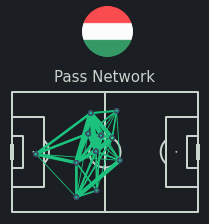

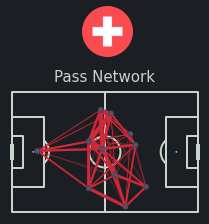

In [680]:
def pass_network(df, team, marker_color):
    
    ################## Data Cleansing Section ##################
    
    # Keeping only the selected team records
    df = df[df['team'] == team]
    
    # Creating dataframe only of substitution records
    subs = df[df['type_display_name'] == 'SubstitutionOff']
    # Only keeping the minute variable of this new sub df
    subs = subs['minute']
    first_sub = subs.min()
    
    # Keeping the data only with records before first substitution
    df = df[df['minute'] < first_sub].reset_index()
    
    # Creating new variables
    df['passer'] = df['name']
    df['receiver'] = df['name'].shift(-1)
    
    # Only interested in successful passes
    df = df[df['type_display_name'] == 'Pass']
    df = df[df['outcome_type_display_name'] == 'Successful']
    
    # Calculating Average Locations of Players
    avg_locations = df.groupby('passer').agg({'x':['mean'], 'y':['mean', 'count']})
    avg_locations.columns = ['x', 'y', 'count']
    avg_locations
    
    # Passes between players (Count of Associations)
    pass_between = df.groupby(['passer', 'receiver']).id.count().reset_index()
    pass_between.rename({'id':'pass_count'}, axis='columns', inplace=True)
    
    # Merging DataFrames
    pass_between = pass_between.merge(avg_locations, left_on='passer',right_index=True)
    pass_between = pass_between.merge(avg_locations, left_on='receiver',right_index=True,suffixes=['','_end'])
    
    ################## Pitch Generation Section ##################
    
    # Setting the text color (labels and texts)
    rcParams['text.color'] = '#c7d5cc'
    
    # Setting parameters for Plotting
    max_line_width = 5
    max_marker_size = 15
    szobo_marker_size = 15

    # Adjusting marker size based on the passer (Szoboslai)
    pass_between['marker_size'] = pass_between.apply(lambda row: szobo_marker_size if row['passer'] == 'Dominik Szoboszlai' else max_marker_size, axis=1)
    pass_between['marker_color'] = pass_between.apply(lambda row: '#21FF77' if row['passer'] == 'Dominik Szoboszlai' else marker_color, axis=1)

    # Setting up the width of the pass lines
    pass_between['width'] = (pass_between.pass_count / pass_between.pass_count.max() * max_line_width)

    # Setting color for pass connections involving Szoboslai
    # Setting up a Player B just in case for future modifications
    pass_between['line_color'] = pass_between.apply(lambda row: '#1CC17D' if row['passer'] == 'Dominik Szoboszlai' or row['passer'] == 'Player B' else marker_color, axis=1)

    rcParams['text.color'] = '#c7d5cc'
    
    # Plotting
    pitch = Pitch(pitch_type='opta', pitch_color='#1B1E22', line_color='#c7d5cc')
    fig, ax = pitch.draw(figsize=(3.5, 3.5), constrained_layout=True, tight_layout=False)
    fig.set_facecolor("#1B1E22")
    
    # Drawing the pass lines (links/edges)
    pass_lines = pitch.lines(pass_between.x, pass_between.y,
                         pass_between.x_end, pass_between.y_end, lw=pass_between.width,
                         color=pass_between.line_color, zorder=1, ax=ax)

    # Drawing the nodes (players)
    nodes = pitch.scatter(pass_between.x, pass_between.y, s=pass_between.marker_size,
                      color=pass_between.marker_color, edgecolors='#3a506b', linewidth=1.5, alpha=1, zorder=1, ax=ax)

    # Labeling the nodes with player name
    #for i, txt in enumerate(pass_between['passer']):
     #   ax.annotate(txt, (pass_between.x.iloc[i], pass_between.y.iloc[i]), color='#A3D3D3', fontsize=5, ha='center', va='bottom',xytext=(0, 12), textcoords='offset points')

    # Setting the title
    ax_title = ax.set_title(f'Pass Network', fontsize=15) #, color='white')
    
    # Adding the image
    image_path = f'/Users/enzovillafuerte/Desktop/Python_Projects/Hungary_Euro_Report/Team_Logos/{team}.png'
    team_logo = Image.open(image_path)

    # Define the position and size of the image (left, bottom, width, height)
    photo_ax = fig.add_axes([0.42, 0.88, 0.2, 0.2])  # Adjust the coordinates and size as needed
    photo_ax.set_facecolor("#22312b")

    photo_ax.imshow(team_logo)
    photo_ax.axis('off')
    
    # Saving Picture
    fig.savefig(f'/Users/enzovillafuerte/Desktop/Python_Projects/Hungary_Euro_Report/Images/Pass_Network_{team}.png', bbox_inches='tight')
    
    print('Successful Run')

# Running the function    
pass_network(final_df, unique_teams[0], color_home) 
pass_network(final_df, unique_teams[1], color_away) 

#--------------------------------------------------------------------------------------------------#
## Passes Performed
#--------------------------------------------------------------------------------------------------#

Successful Run
Successful Run


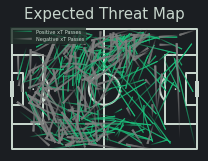

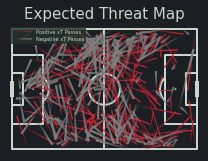

In [659]:
def xT_grid(df, team, color):
    
    # Keeping only specific Team records
    df = df.loc[(df['team'] == team) & (df['type_display_name']=='Pass') & (df['outcome_type_display_name']=='Successful')]
    df.reset_index(inplace=True)
    
    # Simulating xT scores for each section of the field
    # Importing from a different directory
    xT = pd.read_csv('/Users/enzovillafuerte/Desktop/Futbol Analytics Club/AGREF/xT_Grid.csv', header=None)
    
    # Converting values into array
    xT = np.array(xT)
    xT_rows, xT_cols = xT.shape
    
    # Categorizing each record in a bin for starting point and ending point
    df['x1_bin'] = pd.cut(df['x'], bins = xT_cols, labels=False)
    df['y1_bin'] = pd.cut(df['y'], bins = xT_rows, labels=False)

    df['x2_bin'] = pd.cut(df['end_x'], bins = xT_cols, labels=False)
    df['y2_bin'] = pd.cut(df['end_y'], bins = xT_rows, labels=False)
    
    # Defining start zone and end zone values of passes (kinda like x,y coordinates in a map plot)
    df['start_zone_value'] = df[['x1_bin', 'y1_bin']].apply(lambda x: xT[x[1]][x[0]],axis=1)
    df['end_zone_value'] = df[['x2_bin', 'y2_bin']].apply(lambda x: xT[x[1]][x[0]],axis=1)

    # The difference of end_zone and start_zone is the expected threat value for the action (pass) - not accounting for dribble xT here
    # Value can be negative or positive (progressive)
    df['Pass xT'] = df['end_zone_value'] - df['start_zone_value']
    # Progressive xT measures progressive passes
    df['Progressive xT'] = ''
    
    # Iterating and filling values for Progressive xT
    counter = 0 

    while counter < len(df):
        if df['Pass xT'][counter] > 0:
            df['Progressive xT'][counter] = df['Pass xT'][counter]
        else:
            df['Progressive xT'][counter] = 0.00
        counter += 1

        
    ################## xT Generation Section ##################
    import matplotlib.pyplot as plt
    from matplotlib import rcParams
    from mplsoccer import Pitch, VerticalPitch, FontManager, Sbopen
    
    # Setting teh color of the pitch text
    rcParams['text.color'] = '#c7d5cc'
    
    # Keeping only Progressive xT that are not 0
    mask_positive = df['Progressive xT'] != 0
    
    # Setup the pitch
    pitch = Pitch(pitch_type='opta', pitch_color='#1B1E22', line_color='#c7d5cc')
    fig, ax = pitch.draw(figsize=(3, 6), constrained_layout=False, tight_layout=True)
    fig.set_facecolor('#1B1E22')

    lc1 = pitch.lines(df[mask_positive].x, df[mask_positive].y,
                      df[mask_positive].end_x, df[mask_positive].end_y,
                      lw=1, transparent=True, comet=True, label='Positive xT Passes',
                      color=color, ax=ax)
    # yellow: #ad993c

    lc2 = pitch.lines(df[~mask_positive].x, df[~mask_positive].y,
                      df[~mask_positive].end_x, df[~mask_positive].end_y,
                      lw=2, transparent=True, comet=True, label='Negative xT Passes',
                      color='#808080', ax=ax)

    # Plot the legend
    ax.legend(facecolor='#22312b', edgecolor='None', fontsize=5, loc='upper left', handlelength=4)

    # Set the title
    ax_title = ax.set_title(f'Expected Threat Map', fontsize=15)
    
    fig.savefig(f'/Users/enzovillafuerte/Desktop/Python_Projects/Hungary_Euro_Report/Images/xT_Map_{team}.png', bbox_inches='tight')
    
    print('Successful Run')

    
# Running the Functions                 
xT_grid(final_df, unique_teams[0], color_home)
xT_grid(final_df, unique_teams[1], color_away)              

#--------------------------------------------------------------------------------------------------#
## Colored Grid
#--------------------------------------------------------------------------------------------------#

Successful Run


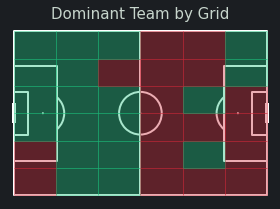

In [660]:
team_colors = {'Team A': '#1f77b4', 'Team B': '#ff7f0e'}  # Define team colors

def dominance_plot(df, team1, team2):
    
    # Drawing the pitch
    pitch = Pitch(pitch_type='opta', pitch_color='#1B1E22', line_color='white')
    fig, ax = pitch.draw(figsize=(4, 3), constrained_layout=False, tight_layout=True)
    fig.set_facecolor('#1B1E22')
    
    # Example usage
    team_colors = {team1: '#1CC17D', team2: '#CE2939'}  # Define team colors
    teams = ['Team A', 'Team B']
    
    # Defining pitch dimensions and grid size
    pitch_length = 100
    pitch_width = 100
    grid_cols = 6
    grid_rows = 6

    # Creating bins for x and y coordinates
    x_bins = np.linspace(0, pitch_length, grid_cols + 1)
    y_bins = np.linspace(0, pitch_width, grid_rows + 1)

    # Creating a DataFrame to count passes per team in each grid cell
    grid_counts = pd.DataFrame(0, index=pd.MultiIndex.from_product([range(grid_rows), range(grid_cols)], names=['y_bin', 'x_bin']), columns=[team1, team2])

    # Binning the passes into the grid
    df['x_bin'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)
    df['y_bin'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)

    # Counting passes per team in each grid cell
    for t in [team1, team2]:
        team_passes = df[df['team'] == t].groupby(['y_bin', 'x_bin']).size()
        grid_counts[t].update(team_passes)
        
    # Determining the dominant team in each grid cell
    grid_counts['dominant_team'] = grid_counts.idxmax(axis=1)

    # Plotting each grid cell with the color of the dominant team
    for y in range(grid_rows):
        for x in range(grid_cols):
            dominant_team = grid_counts.loc[(y, x), 'dominant_team']
            color = team_colors[dominant_team]
            rect = plt.Rectangle((x_bins[x], y_bins[y]), x_bins[1] - x_bins[0], y_bins[1] - y_bins[0], color=color, alpha=0.38, edgecolor='#1B1E22')
            ax.add_patch(rect)
            
    # Setting teh color of the pitch text
    rcParams['text.color'] = '#c7d5cc'
    
    # Title and legend
    ax.set_title('Dominant Team by Grid', fontsize=15)
    handles = [plt.Line2D([0], [0], marker='s', color='w', label=t, markersize=10, markerfacecolor=color) for t, color in team_colors.items()]
    #ax.legend(handles=handles, title='Teams', loc='upper right', bbox_to_anchor=(1.15, 1))

    fig.savefig(f'/Users/enzovillafuerte/Desktop/Python_Projects/Hungary_Euro_Report/Images/Dominant_Team_Grid.png', bbox_inches='tight')
    
    print('Successful Run')

        
    
dominance_plot(final_df, unique_teams[0], unique_teams[1])
    

#--------------------------------------------------------------------------------------------------#
## All actions heatmap
#--------------------------------------------------------------------------------------------------#

Successful Run
Successful Run


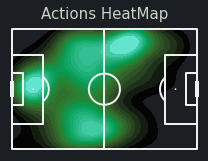

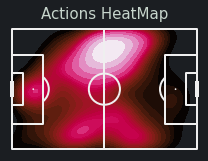

In [661]:
# Link: https://mplsoccer.readthedocs.io/en/latest/gallery/pitch_plots/plot_cmap.html#sphx-glr-gallery-pitch-plots-plot-cmap-py

def all_heatmap(df, team, cmr):
    
    # Keeping only specific Team records
    df = df.loc[(df['team'] == team)]
    df.reset_index(inplace=True)
    
    # Filtering events
    df = df[['x', 'y']]
    
    # Creating Pithc
    pitch = Pitch(pitch_type='opta', line_zorder=2,
                  pitch_color='#1B1E22', line_color='#efefef')
    
    
    # Drawing Pitch
    fig, ax = pitch.draw(figsize=(3, 6), constrained_layout=False, tight_layout=True)
    fig.set_facecolor('#1B1E22')
    
    # Apply heatmap
    kdeplot_dark = pitch.kdeplot(df.x, df.y, ax=ax, cmap=cmr, fill=True, levels=20)
    
    # Setting teh color of the pitch text
    rcParams['text.color'] = '#c7d5cc'
    
    # Title and legend
    ax.set_title('Actions HeatMap', fontsize=15)

    fig.savefig(f'/Users/enzovillafuerte/Desktop/Python_Projects/Hungary_Euro_Report/Images/Actions_Heamap_{team}.png', bbox_inches='tight')
    
    print('Successful Run')


all_heatmap(final_df, unique_teams[0], cmr.emerald)
all_heatmap(final_df, unique_teams[1], cmr.flamingo)

#--------------------------------------------------------------------------------------------------#
## Pass Flow Map
https://mplsoccer.readthedocs.io/en/latest/gallery/pitch_plots/plot_flow.html#sphx-glr-gallery-pitch-plots-plot-flow-py
#--------------------------------------------------------------------------------------------------#

Successful Run
Successful Run


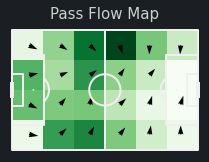

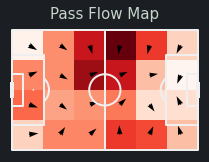

In [662]:
def pass_flow_plot(df, team, cmap):
    
    # Keeping only specific Team records
    df = df.loc[(df['team'] == team)]
    df.reset_index(inplace=True)
    
    # Filtering datasets to only include one teams passes and get boolean mask for the completed passes
    df_pass = df[['x', 'y', 'end_x', 'end_y', 'outcome_type_display_name']]
    #df_pass = df_pass.outcome_type_display_name.isnull()
    
    # Removing rows with NaN values in the key columns
    df_pass = df_pass.dropna(subset=['x', 'y', 'end_x', 'end_y'])
    
    # Converting coordinates to numeric (in case they are not)
    df_pass[['x', 'y', 'end_x', 'end_y']] = df_pass[['x', 'y', 'end_x', 'end_y']].apply(pd.to_numeric, errors='coerce')
    
    # Removing any rows that still have NaN values after conversion
    df_pass = df_pass.dropna(subset=['x', 'y', 'end_x', 'end_y'])
    
    # Setting up pitch and number of bins
    pitch = Pitch(pitch_type='opta',  line_zorder=2, line_color='#efefef', pitch_color='#1B1E22')
    bins = (6, 4)
    
    fig, ax = pitch.draw(figsize=(3.5,6), constrained_layout=True, tight_layout=False)
    fig.set_facecolor('#1B1E22')
    
    # Plotting heatmap - darker colors equals more passes originating from that source
    bs_heatmap = pitch.bin_statistic(df_pass.x, df_pass.y, statistic='count', bins=bins)
    hm = pitch.heatmap(bs_heatmap, ax=ax, cmap=cmap)
    
    # Plotting the arrows flow map
    m = pitch.flow(df_pass.x, df_pass.y, df_pass.end_x, df_pass.end_y,
                color='black', arrow_type='same',
                arrow_length=5, bins=bins, ax=ax)
    
    # Setting teh color of the pitch text
    rcParams['text.color'] = '#c7d5cc'
    
    # Title and legend
    ax.set_title('Pass Flow Map', fontsize=15)

    fig.savefig(f'/Users/enzovillafuerte/Desktop/Python_Projects/Hungary_Euro_Report/Images/Pass_Flow_{team}.png',bbox_inches='tight')
    
    print('Successful Run')
    
    
pass_flow_plot(final_df, unique_teams[0], 'Greens')
pass_flow_plot(final_df, unique_teams[1], 'Reds')

#--------------------------------------------------------------------------------------------------#
## Shots
Jointgrid: https://mplsoccer.readthedocs.io/en/latest/gallery/pitch_plots/plot_jointgrid.html#sphx-glr-gallery-pitch-plots-plot-jointgrid-py
#--------------------------------------------------------------------------------------------------#

Successful Run


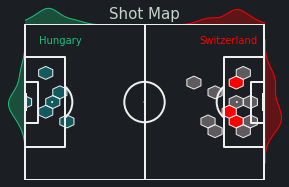

In [663]:
def shot_jointgrid(df):
    # Ensure relevant columns are numeric and handle non-numeric values
    df['x'] = pd.to_numeric(df['x'], errors='coerce')
    df['y'] = pd.to_numeric(df['y'], errors='coerce')
    df['is_shot'] = df['is_shot'].astype(bool)
    
    # Filtering to include only the shots
    df_shots = df[df.is_shot].copy()
    
    # Subseting the two teams
    team1, team2 = df_shots.team.unique()
    df_team1 = df_shots[df_shots.team == team1].copy()
    df_team2 = df_shots[df_shots.team == team2].copy()
    
    # Setup the mplsoccer Pitch
    pitch = Pitch(pad_top=0.05, pad_right=0.05, pad_bottom=0.05, pad_left=0.05, 
                  line_zorder=2, pitch_type='opta', line_color='#efefef', pitch_color='#1B1E22')
    
    # Shift the coordinates for team1
    df_team1['x'] = pitch.dim.right - df_team1.x
    
    fig, axs = pitch.jointgrid(figheight=3, left=None, bottom=0.075, grid_height=0.8,
                               axis=False, endnote_height=0, title_height=0)
    
    fig.set_facecolor('#1B1E22')
    
    # Define custom colormaps
    reds = LinearSegmentedColormap.from_list('custom_greens', [(0, 0.9, 0.9, 0.3), (0, 1, 0, 1)])
    blues = LinearSegmentedColormap.from_list('custom_reds', [(1, 0.9, 0.9, 0.3), (1, 0, 0, 1)])
    
    # Plot the hexbins
    hex1 = pitch.hexbin(df_team1.x, df_team1.y, ax=axs['pitch'],
                        edgecolors=pitch.line_color, cmap=reds)
    hex2 = pitch.hexbin(df_team2.x, df_team2.y, ax=axs['pitch'],
                        edgecolors=pitch.line_color, cmap=blues)
    
    # Normalize the values so the colors depend on the minimum/maximum value for both teams
    vmin = min(hex1.get_array().min(), hex2.get_array().min())
    vmax = max(hex1.get_array().max(), hex2.get_array().max())
    hex1.set_clim(vmin=vmin, vmax=vmax)
    hex2.set_clim(vmin=vmin, vmax=vmax)
    
    # Define colors
    red = '#1CC17D'
    blue = 'red'
    
    # Plot KDE plots on the marginals
    sns.kdeplot(y=df_team1.y, ax=axs['left'], color=red, fill=True, alpha=0.3)
    sns.kdeplot(x=df_team1.x, ax=axs['top'], color=red, fill=True, alpha=0.3)
    sns.kdeplot(x=df_team2.x, ax=axs['top'], color=blue, fill=True, alpha=0.3)
    sns.kdeplot(y=df_team2.y, ax=axs['right'], color=blue, fill=True, alpha=0.3)
    
    # Add team names
    axs['pitch'].text(x=15, y=90, s=team1, color=red, ha='center', va='center', fontsize=10)
    axs['pitch'].text(x=85, y=90, s=team2, color=blue, ha='center', va='center', fontsize=10)

    # Setting teh color of the pitch text
    rcParams['text.color'] = '#c7d5cc'
    
    # Title and legend
    axs['pitch'].set_title('Shot Map', fontsize=15)

    fig.savefig(f'/Users/enzovillafuerte/Desktop/Python_Projects/Hungary_Euro_Report/Images/Pass_Flow_{team1}_vs_{team2}.png', bbox_inches='tight')
    
    print('Successful Run')

# final_df should contain the columns 'x', 'y', 'is_shot', and 'team'
shot_jointgrid(final_df)

#--------------------------------------------------------------------------------------------------#
## Defensive Actions
#--------------------------------------------------------------------------------------------------#

Successful Run
Successful Run


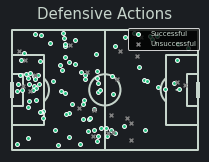

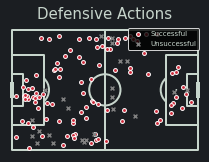

In [664]:
def defensive_actions(df, team, succ_color):
    
    # Keeping only specific Team records
    df = df.loc[(df['team'] == team)]
    df.reset_index(inplace=True)
    df = df[df['type_display_name'].isin(['Interception', 'BallRecovery','Tackle', 'BlockedPass', 'Challenge', 'Clearance', 'Aerial', 'SavedShot'])]
    
    # Plotting 
    pitch = Pitch(pitch_type='opta', pitch_color='#1B1E22', line_color='#c7d5cc')
    fig, ax = pitch.draw(figsize=(3.5, 3.5), constrained_layout=True, tight_layout=False)
    fig.set_facecolor("#1B1E22")
    
    # Defining marker styles for different types of defensive actions
    outcome_styles = {
        'Successful': 'o',  # Circle marker
        'Unsuccessful': 'x' # X marker
    }
    
    # Defining colors for successful and unsuccessful outcomes
    outcome_colors = {
        'Successful': succ_color, # '#1CC17D'
        'Unsuccessful': 'gray'
    }
    
    
    # Plotting defensive actions with different marker styles and colors
    for outcome_type, marker_style in outcome_styles.items():
        outcome_actions = df[df['outcome_type_display_name'] == outcome_type]
        ax.scatter(outcome_actions['x'], outcome_actions['y'], color=outcome_colors[outcome_type], edgecolors='white', marker=marker_style, s=15, zorder=3, label=outcome_type)
        
    # Adding a legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper right', facecolor='black', edgecolor='white', fontsize=7)
    
    # Setting teh color of the pitch text
    rcParams['text.color'] = '#c7d5cc'
    
    # Title and legend
    ax.set_title('Defensive Actions', fontsize=15)

    fig.savefig(f'/Users/enzovillafuerte/Desktop/Python_Projects/Hungary_Euro_Report/Images/Defensive_Actions_{team}.png', bbox_inches='tight')
    
    print('Successful Run')
    

defensive_actions(final_df, unique_teams[0], color_home)
defensive_actions(final_df, unique_teams[1], color_away)

#--------------------------------------------------------------------------------------------------#
## xT Momentum
#--------------------------------------------------------------------------------------------------#

Successful Run


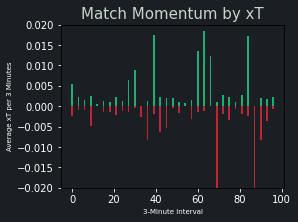

In [665]:
def xT_momentum(df): 
    
    # Subseting the two teams
    team1, team2 = df.team.unique()
    
    # Keeping only specific Team records
    df = df.loc[(df['type_display_name']=='Pass') & (df['outcome_type_display_name']=='Successful')]
    df.reset_index(inplace=True)
    
    # Simulating xT scores for each section of the field
    # Importing from a different directory
    xT = pd.read_csv('/Users/enzovillafuerte/Desktop/Futbol Analytics Club/AGREF/xT_Grid.csv', header=None)
    
    # Converting values into array
    xT = np.array(xT)
    xT_rows, xT_cols = xT.shape
    
    # Categorizing each record in a bin for starting point and ending point
    df['x1_bin'] = pd.cut(df['x'], bins=xT_cols, labels=False)
    df['y1_bin'] = pd.cut(df['y'], bins=xT_rows, labels=False)

    df['x2_bin'] = pd.cut(df['end_x'], bins=xT_cols, labels=False)
    df['y2_bin'] = pd.cut(df['end_y'], bins=xT_rows, labels=False)
    
    # Defining start zone and end zone values of passes (kinda like x,y coordinates in a map plot)
    df['start_zone_value'] = df[['x1_bin', 'y1_bin']].apply(lambda x: xT[x[1]][x[0]], axis=1)
    df['end_zone_value'] = df[['x2_bin', 'y2_bin']].apply(lambda x: xT[x[1]][x[0]], axis=1)

    # Calculating the expected threat value for each pass
    df['Pass xT'] = df['end_zone_value'] - df['start_zone_value']
    df['Progressive xT'] = df['Pass xT'].clip(lower=0)  # Progressive xT measures positive xT only
    
    # Grouping the DataFrame by every 3 minutes and team to calculate the average xT per 3 minutes for each team
    df['minute_group'] = (df['minute'] // 3) * 3  # Create bins of 3 minutes each
    avg_xT_per_3_minutes = df.groupby(['minute_group', 'team'])['Progressive xT'].mean().unstack()
    
    # Plot the Match Momentum by xT Chart
    fig, ax = plt.subplots(figsize=(4, 3))
    
    fig.set_facecolor("#1B1E22")
    ax.set_facecolor("#1B1E22")
    
    # Plot double-sided bar charts for home and away teams
    for team in avg_xT_per_3_minutes.columns:
        if team == team1:
            ax.bar(avg_xT_per_3_minutes.index, avg_xT_per_3_minutes[team], color='#1CC17D', alpha=0.9, label=team)
        elif team == team2:
            ax.bar(avg_xT_per_3_minutes.index, -avg_xT_per_3_minutes[team], color='#CE2939', alpha=0.9, label=team)
     
    # Setting teh color of the pitch text
    rcParams['text.color'] = '#c7d5cc'
    
    # Add labels and title
    ax.set_xlabel('3-Minute Interval', color='white', fontsize=7)
    ax.set_ylabel('Average xT per 3 Minutes', color='white', fontsize=7)
    ax.set_title('Match Momentum by xT', fontsize=15)
    
    # Set axis color to white
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    
    
    # ax.set_ylim('log')
    ax.set_ylim(bottom=-0.02, top=0.02)
    
    fig.savefig(f'/Users/enzovillafuerte/Desktop/Python_Projects/Hungary_Euro_Report/Images/Xt_Momentum_{team1}vs{team2}.png', bbox_inches='tight')
    
    print('Successful Run')
    
    return

xT_momentum(final_df)

#--------------------------------------------------------------------------------------------------#
## xG FlowChart
To be developed later. Need to do some modifications in the scrapping
#--------------------------------------------------------------------------------------------------#

# Report Generation

In [666]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from highlight_text import fig_text
from PIL import Image
import urllib
from mplsoccer import Radar, FontManager, grid
import numpy as np
import matplotlib.patheffects as path_effects
from highlight_text import ax_text, fig_text
from pathlib import Path
from urllib.request import urlopen
from io import BytesIO
import requests
import os
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from reportlab.lib import colors
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle
from reportlab.pdfbase.ttfonts import TTFont
from reportlab.pdfbase import pdfmetrics
from PIL import Image
import pandas as pd
import urllib

## Fotmob Logos

In [667]:
fotmob_url = "https://images.fotmob.com/image_resources/logo/teamlogo/"

dict_teams = {
    ############ EUROS ########
    'Hungary':8565,
    'Switzerland': 6717,
    'Germany': 8570,
    'Scotland':8498,
    'Albania': 10024,
    'Croatia': 10155,
    'Italy': 8204,
    'Spain': 6720,
    'Denmark': 8238,
    'England': 8491,
    'Serbia': 8205,
    'Slovenia': 5787,
    'Austria': 8255,
    'France': 6723,
    'Netherlands': 6708,
    'Poland': 8568,
    'Belgium': 8263,
    'Romania': 9730,
    'Slovakia': 8497,
    'Ukraine': 6718,
    'Czechia': 8496,
    'Georgia': 8268,
    'Portugal': 8361, 
    'Turkiye': 6595,
    ############ COPA AMERICA ########
    'Argentina': 6706,
    'Canada': 5810,
    'Chile': 9762,
    'Peru': 5798,
    'Ecuador': 6707,
    'Jamaica': 5806,
    'Mexico': 6710,
    'Venezuela': 5800,
    'Bolivia': 5797,
    'Panama':5922,
    'USA': 6713,
    'Uruguay': 5796,
    'Brazil': 8256,
    'Colombia': 8258,
    'Costa Rica': 6705,
    'Paraguay': 6724
}

# set up download directory
download_directory = '/Users/enzovillafuerte/Desktop/Python_Projects/Hungary_Euro_Report/Team_Logos'

# create the directory if it doesn't exist
os.makedirs(download_directory, exist_ok=True)

# download images and save in directory
for team, team_id in dict_teams.items():
    url = f"{fotmob_url}{team_id}.png"
    response = requests.get(url)
    if response.status_code == 200:
        with open(os.path.join(download_directory, f"{team}.png"), 'wb') as file:
            file.write(response.content)
            print(f"Downloaded: {team}")
    else:
            print(f"Failed to download: {team}")

Downloaded: Hungary
Downloaded: Switzerland
Downloaded: Germany
Downloaded: Scotland
Downloaded: Albania
Downloaded: Croatia
Downloaded: Italy
Downloaded: Spain
Downloaded: Denmark
Downloaded: England
Downloaded: Serbia
Downloaded: Slovenia
Downloaded: Austria
Downloaded: France
Downloaded: Netherlands
Downloaded: Poland
Downloaded: Belgium
Downloaded: Romania
Downloaded: Slovakia
Downloaded: Ukraine
Downloaded: Czechia
Downloaded: Georgia
Downloaded: Portugal
Downloaded: Turkiye
Downloaded: Argentina
Downloaded: Canada
Downloaded: Chile
Downloaded: Peru
Downloaded: Ecuador
Downloaded: Jamaica
Downloaded: Mexico
Downloaded: Venezuela
Downloaded: Bolivia
Downloaded: Panama
Downloaded: USA
Downloaded: Uruguay
Downloaded: Brazil
Downloaded: Colombia
Downloaded: Costa Rica
Downloaded: Paraguay


In [682]:
def report_generation(df, home, away):
    
    # Prefixing the Width and Height of the Report
    width, height = 780, 900
    
    # Creating the canvas in the appropiate directory
    c = canvas.Canvas(f'/Users/enzovillafuerte/Desktop/Python_Projects/Hungary_Euro_Report/Reports/{home} vs {away}.pdf', pagesize=(width, height))
    ''' BACKGROUND COLOR '''
    c.setFillColorRGB(0.10588235, 0.11764706, 0.13333333)  
    c.rect(0, 0, 780, 900, fill=True)
    
    ######################## HOME TEAM ########################
    
    # Heatmap
    c.drawImage(f'/Users/enzovillafuerte/Desktop/Python_Projects/Hungary_Euro_Report/Images/Actions_Heamap_{home}.png', 10, 15)#, width=270, height=220)
    # xT Passes
    c.drawImage(f'/Users/enzovillafuerte/Desktop/Python_Projects/Hungary_Euro_Report/Images/xT_Map_{home}.png', 10, 180)
    # Defensive Actions
    c.drawImage(f'/Users/enzovillafuerte/Desktop/Python_Projects/Hungary_Euro_Report/Images/Defensive_Actions_{home}.png', 10, 345)
    # Pass Flow
    c.drawImage(f'/Users/enzovillafuerte/Desktop/Python_Projects/Hungary_Euro_Report/Images/Pass_Flow_{home}.png', 10, 510)
    # Pass Network
    c.drawImage(f'/Users/enzovillafuerte/Desktop/Python_Projects/Hungary_Euro_Report/Images/Pass_Network_{home}.png', 10, 675)
    
    
    
    ######################## AWAY TEAM ########################480
    
    # Heatmap
    c.drawImage(f'/Users/enzovillafuerte/Desktop/Python_Projects/Hungary_Euro_Report/Images/Actions_Heamap_{away}.png', 560, 15)#, width=270, height=220)
    # xT Passes
    c.drawImage(f'/Users/enzovillafuerte/Desktop/Python_Projects/Hungary_Euro_Report/Images/xT_Map_{away}.png', 560, 180)
    # Defensive Actions
    c.drawImage(f'/Users/enzovillafuerte/Desktop/Python_Projects/Hungary_Euro_Report/Images/Defensive_Actions_{away}.png', 560, 345)
    # Pass Flow
    c.drawImage(f'/Users/enzovillafuerte/Desktop/Python_Projects/Hungary_Euro_Report/Images/Pass_Flow_{away}.png', 560, 510)
    # Pass Network
    c.drawImage(f'/Users/enzovillafuerte/Desktop/Python_Projects/Hungary_Euro_Report/Images/Pass_Network_{away}.png', 560, 675)
    
    ######################## GENERAL ########################
    c.drawImage(f'/Users/enzovillafuerte/Desktop/Python_Projects/Hungary_Euro_Report/Images/Xt_Momentum_{home}vs{away}.png', 240, 295)
    c.drawImage(f'/Users/enzovillafuerte/Desktop/Python_Projects/Hungary_Euro_Report/Images/Dominant_Team_Grid.png', 250, 70)
    c.drawImage(f'/Users/enzovillafuerte/Desktop/Python_Projects/Hungary_Euro_Report/Images/Pass_Flow_{home}_vs_{away}.png', 250, 530)
    
    ##################### LOGOS #####################
    # c.drawImage(f'/Users/enzovillafuerte/Desktop/Python_Projects/Hungary_Euro_Report/Team_Logos/Euros.png', 250, 530)
    #c.drawImage(f'/Users/enzovillafuerte/Desktop/Python_Projects/Hungary_Euro_Report/Team_Logos/Hungary.png', 90, 840, width=50, height=50)
    #c.drawImage(f'/Users/enzovillafuerte/Desktop/Python_Projects/Hungary_Euro_Report/Team_Logos/Switzerland.png', 640, 840, width=50, height=50)
    
    ##################### TEXT #####################
    
    ''' TEXT '''
    URL4 = 'https://raw.githubusercontent.com/googlefonts/roboto/main/src/hinted/Roboto-Thin.ttf'
    font_data = BytesIO(urlopen(URL4).read())
    pdfmetrics.registerFont(TTFont('RobotoThin', font_data))

    ############ Title
    c.setFont('RobotoThin', 40)
    #c.setFillColorRGB(1,1,1)  # Set text color to white
    c.setFillColor('white')
    title = f"{home} vs"
    c.drawString(260, 850, title)
    
    c.setFont('RobotoThin', 40)
    #c.setFillColorRGB(1,1,1)  # Set text color to white
    c.setFillColor('white')
    title = f"{away}"
    c.drawString(260, 810, title)
    
    c.setFont('RobotoThin', 70)
    #c.setFillColorRGB(1,1,1)  # Set text color to white
    c.setFillColor('white')
    title = f"1-3"
    c.drawString(350, 730, title)
    
    c.setFont('RobotoThin', 15)
    #c.setFillColorRGB(1,1,1)  # Set text color to white
    c.setFillColor('white')
    title = f"By: Enzo Villafuerte"
    c.drawString(335, 50, title)
    
    c.setFont('RobotoThin', 12)
    #c.setFillColorRGB(1,1,1)  # Set text color to white
    c.setFillColor('white')
    title = f"Data via Opta"
    c.drawString(365, 30, title)
    
    # Save and close the PDF file
    c.save()
    
report_generation(final_df, unique_teams[0], unique_teams[1])